<a href="https://colab.research.google.com/github/Upset-Downset/Upset-Downset/blob/master/cross_entropy_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Upset-Downset/Upset-Downset.git

Cloning into 'Upset-Downset'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 224 (delta 8), reused 13 (delta 0), pack-reused 192
Receiving objects: 100% (224/224), 103.32 KiB | 351.00 KiB/s, done.
Resolving deltas: 100% (105/105), done.


In [ ]:
%cd /content/Upset-Downset
!git pull https://github.com/Upset-Downset/Upset-Downset.git

In [11]:
import randomUpDown as rud
import agents.gameState as state
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


# Train on games of size n_actions or less (n_action starts at 10)
n_actions = 10
initial_game = rud.RandomGame(n_actions, colored=True)
initial_state = state.game_state(initial_game, n=n_actions)
initial_state_mat = initial_state.matrix
initial_state_vec = initial_state_mat.reshape(n_actions * n_actions)
initial_state_vec

array([2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2.])

In [12]:
from sklearn.neural_network import MLPClassifier

up_agent = MLPClassifier(
    hidden_layer_sizes=(1000, 1000),
    activation='tanh',
)

down_agent = MLPClassifier(
    hidden_layer_sizes=(1000, 1000),
    activation='tanh',
)

# Initialize agents to the dimension of state space and number of actions
up_agent.partial_fit(X = [initial_state_vec] * n_actions, y = np.arange(n_actions), classes = np.arange(n_actions))
down_agent.partial_fit(X = [initial_state_vec] * n_actions, y = np.arange(n_actions), classes = np.arange(n_actions))

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000, 1000), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [13]:
def generate_play(game, up_agent, down_agent, start = 'Up'):
  '''
  play a single game of upset-downset using the up_agent and down_agent. Returns 
  the states encountered, actions taken at each state and total reward for each
  agent.
  '''
  #initializing trackers
  up_states, up_actions = [], []
  down_states, down_actions = [], []
  up_reward, down_reward = 0, 0

  #initial state
  cur_state = state.game_state(game, n=n_actions)
  state_mat = cur_state.matrix
  state_vec = state_mat.reshape(n_actions * n_actions)
  
  #the diagonal tracks if the game is finished
  diag = np.diag(state_mat)
  
  #initialize the turn token
  turn = start

  while sum(diag) != 0:
    
    #check to see if the game is over by color options
    if set(diag) == {0,1}:
      #set the token to the loser and break out of the game
      turn = 'Up'
      break
    if set(diag) == {0,3}:
      #set the token to the loser and break out of the game
      turn = 'Down'
      break
    
    if turn == 'Up':
      #get policy
      up_probs = up_agent.predict_proba([state_vec]*n_actions)
      
      #make choice
      node = np.random.choice(range(n_actions), p = up_probs[0])
      while diag[node] in [0,1/3]:
        up_reward -= 10
        node = np.random.choice(range(n_actions), p = up_probs[0])
      removal_set = game.upset(node)

      #update whose turn it is
      turn = 'Down'

    else:
      #get policy
      down_probs = down_agent.predict_proba([state_vec]*n_actions)
      
      #make choice
      node = np.random.choice(range(n_actions), p = down_probs[0])
      while diag[node] in [0,1]:
        down_reward -= 10
        node = np.random.choice(range(n_actions), p = down_probs[0])
      removal_set = game.downset(node)

      #update whose turn it is
      turn = 'Up'

    #store state and action
    if turn == 'Down':
      up_states.append(np.copy(state_vec))
      up_actions.append(node)
    else:
      down_states.append(np.copy(state_vec))
      down_actions.append(node)

    #get current state
    cur_state.update_state(removal_set)

  #play is over. Assign final rewards    
  if turn == 'Up':
    up_reward -= 10
    down_reward += 10
    winner = 'Down'
  else:
    up_reward += 10
    down_reward -= 10
    winner = 'Up'

  return up_states, down_states, up_actions, down_actions, up_reward, down_reward, winner

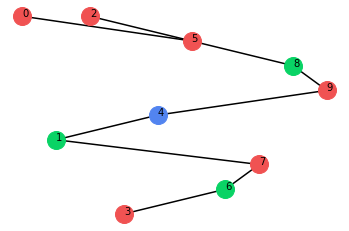

In [14]:
#new game
game = rud.RandomGame(10, colored=True)
game.gameboard()

In [15]:
def gameplay_session(num_plays):
  '''
  play a sequence of 'num_plays' number of games with up_agent/down_agent starting 
  first uniformly randomly. Returns the states encountered (list of 1-D arrays), 
  actions taken (lists of lists) and total reward (list of ints) for each agent 
  in the order they were encountered.
  '''
  up_states, up_actions = [], []
  down_states, down_actions = [], []
  up_rewards, down_rewards = [], []
  up_wins, down_wins = 0, 0
  while num_plays > 0:
      start = np.random.choice(['Up', 'Down'])
      game = rud.RandomGame(n_actions, colored = True)
      gameplay = generate_play(game, up_agent, down_agent, start = start)
      up_states.append(gameplay[0])
      up_actions.append(gameplay[2])
      up_rewards.append(gameplay[4])
      down_states.append(gameplay[1])
      down_actions.append(gameplay[3])
      down_rewards.append(gameplay[5])
      if gameplay[6] == 'Up':
        up_wins += 1
      else:
        down_wins += 1
      num_plays -= 1
  return up_states, down_states, up_actions, down_actions, up_rewards, down_rewards, up_wins, down_wins

In [16]:
def select_elite_plays(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Rerturns the states and corresponding actions from games that have rewards 
    >= percentile.
    """
    reward_threshold = np.percentile(rewards_batch, percentile)    
    num_games = len(states_batch)
    elite_states = []
    elite_actions = []
    for game in range(num_games):
        if rewards_batch[game] >= reward_threshold:
            elite_states.extend(states_batch[game])
            elite_actions.extend(actions_batch[game]) 
    return elite_states, elite_actions

In [21]:
def show_progress(rewards_batch, log, percentile, reward_range=[-1000,+1000]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [24]:
n_sessions = 2
plays_per_session = 10000
percentile = 50
up_log = []
down_log = []

for i in range(n_sessions):
    print('iteration = ', i)
    #generate new sessions
    session = gameplay_session(plays_per_session)
    #get states, actions, rewrads batches from sessions
    up_states_batch, down_states_batch, up_actions_batch, down_actions_batch, \
    up_rewards_batch, down_rewards_batch, up_wins, down_wins = session
    #get up elites from sessions
    up_elite_states, up_elite_actions = \
    select_elite_plays(up_states_batch, up_actions_batch, up_rewards_batch, percentile)
    #get down elites from session
    down_elite_states, down_elite_actions = \
    select_elite_plays(down_states_batch, down_actions_batch, down_rewards_batch, percentile)
    #update up agent
    up_agent.partial_fit(up_elite_states, up_elite_actions)
    #update down agent
    down_agent.partial_fit(down_elite_states, down_elite_actions)
    #show up progress
    #show_progress(up_rewards_batch, up_log, percentile, reward_range=[np.min(up_rewards_batch), np.max(up_rewards_batch)])
    #show down progress
    #show_progress(down_rewards_batch, down_log, percentile, reward_range=[np.min(down_rewards_batch), np.max(down_rewards_batch)])
    print('Up rewards = ', np.mean(up_rewards_batch),'Up wins = ', up_wins, 'Down rewards = ', np.mean(down_rewards_batch), 'Down wins = ', down_wins)

iteration =  0
Up rewards =  -4.729 Up wins =  2663 Down rewards =  -3.221 Down wins =  7337
iteration =  1
Up rewards =  -4.84 Up wins =  2596 Down rewards =  2.879 Down wins =  7404


In [ ]:
session = gameplay_session(100)

In [ ]:
up_states_batch, down_states_batch, up_actions_batch, down_actions_batch, \
    up_rewards_batch, down_rewards_batch, up_wins, down_wins = session

In [25]:
up_wins

2596

In [26]:
down_wins

7404

In [27]:
np.mean(up_rewards_batch)

-4.84

In [28]:
np.mean(down_rewards_batch)

2.879